In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib notebook

from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [2]:
# Load the spam data
data = pd.read_csv('../data/prostate.data',sep='\t',index_col=0)

X_cols = [col for col in data.columns if (col not in ['train','lpsa'])]
y_cols = ['lpsa']

# Scale the columns to mean 0 and var 
scaler = StandardScaler()
data[X_cols] = scaler.fit_transform(data[X_cols])

### Split into training and test data

In [3]:
# # # Split in train/test
train_data = data[data.train=='T']
test_data = data[data.train=='F']

train_data = train_data.drop(['train'],axis=1)
test_data = test_data.drop(['train'],axis=1)

### Training data correlation matix (Table 3.1 on page 50)

In [4]:
train_data[X_cols].corr()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
lcavol,1.000000,0.300232,0.286324,0.063168,0.592949,0.692043,0.426414,0.483161
lweight,0.300232,1.000000,0.316723,0.437042,0.181054,0.156829,0.023558,0.074166
age,0.286324,0.316723,1.000000,0.287346,0.128902,0.172951,0.365915,0.275806
lbph,0.063168,0.437042,0.287346,1.000000,-0.139147,-0.088535,0.032992,-0.030404
svi,0.592949,0.181054,0.128902,-0.139147,1.000000,0.671240,0.306875,0.481358
lcp,0.692043,0.156829,0.172951,-0.088535,0.671240,1.000000,0.476437,0.662533
gleason,0.426414,0.023558,0.365915,0.032992,0.306875,0.476437,1.000000,0.757056
pgg45,0.483161,0.074166,0.275806,-0.030404,0.481358,0.662533,0.757056,1.000000


### Fitting a linear regression (Table 3.2 page 50)

In [5]:
X_train = train_data[X_cols].values
y_train = train_data[y_cols].values

In [6]:
# Linear regression OLS
X_train_ols = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train_ols)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     16.47
Date:                Sun, 24 Mar 2019   Prob (F-statistic):           2.04e-12
Time:                        20:02:53   Log-Likelihood:                -67.505
No. Observations:                  67   AIC:                             153.0
Df Residuals:                      58   BIC:                             172.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4649      0.089     27.598      0.0

### Best subset selection

In [42]:
def fit_linear_reg(X,y):
    #Fit linear regression model and return mse and R squared values
    model_k = LinearRegression(fit_intercept = True)
    model_k.fit(X,y)
    MSE = mean_squared_error(y,model_k.predict(X)) * len(y)
    R_squared = model_k.score(X,y)
    return MSE, R_squared

def fit_stat_linear_reg(X,y):
    X_train_ols = sm.add_constant(X)
    model = sm.OLS(y, X_train_ols)
    results = model.fit()
    return results

In [36]:
import itertools

n_features = len(X_cols)
total_combinations = 2**n_features

results_df = pd.DataFrame(columns=['features','mse','r2','n_features'])
stuff = np.arange(n_features)

rownum = 0
for L in range(0, len(stuff)+1):
    for subset in itertools.combinations(stuff, L):
        if len(subset)>0:
            mse,r2 = fit_linear_reg(X_train[:,subset],y_train)
            results_df.loc[rownum] = [subset, mse, r2, len(subset)]
            rownum = rownum + 1
        

<IPython.core.display.Javascript object>


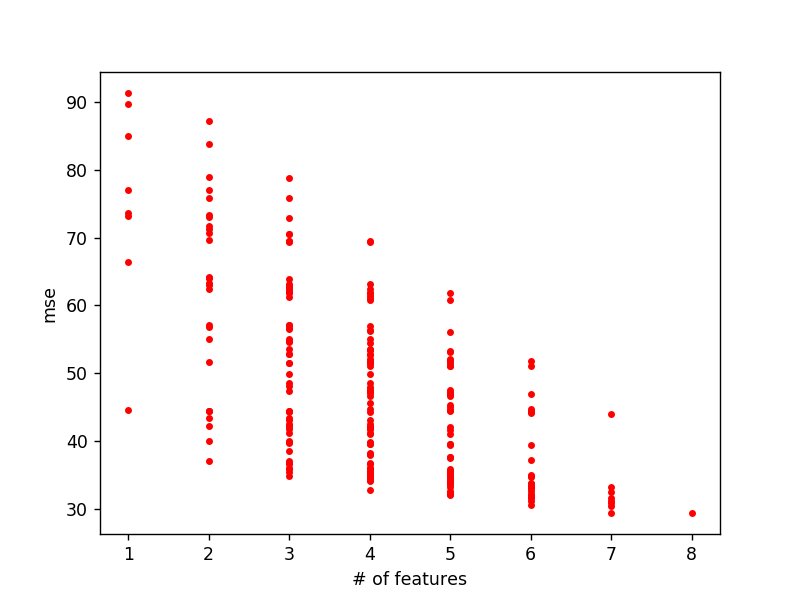

Text(0,0.5,'mse')

In [38]:
fig,ax = plt.subplots()
ax.plot(results_df.n_features,results_df.mse,'r.')
ax.set_xlabel('# of features')
ax.set_ylabel('mse')

### MSE on training data is not repesentative of the actual (test) error of the model. 
### Let's use AIC and BIC first

In [43]:
import itertools

n_features = len(X_cols)
total_combinations = 2**n_features

results_df = pd.DataFrame(columns=['features','n_features','r2','aic','bic'])
stuff = np.arange(n_features)

rownum = 0
for L in range(0, len(stuff)+1):
    for subset in itertools.combinations(stuff, L):
        if len(subset)>0:
            results_fit = fit_stat_linear_reg(X_train[:,subset],y_train)
            results_df.loc[rownum] = [subset, len(subset), results_fit.rsquared, results_fit.aic, results_fit.bic]
            rownum = rownum + 1

<IPython.core.display.Javascript object>


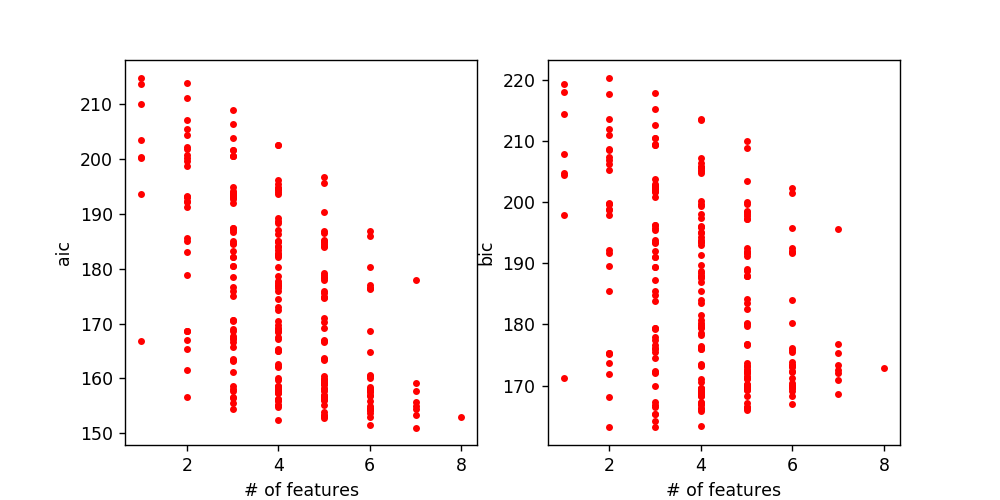

Text(0,0.5,'bic')

In [50]:
fig,ax = plt.subplots(ncols=2,figsize=(8,4))
ax[0].plot(results_df.n_features,results_df.aic,'r.')
ax[0].set_xlabel('# of features')
ax[0].set_ylabel('aic')
ax[1].plot(results_df.n_features,results_df.bic,'r.')
ax[1].set_xlabel('# of features')
ax[1].set_ylabel('bic')

<IPython.core.display.Javascript object>


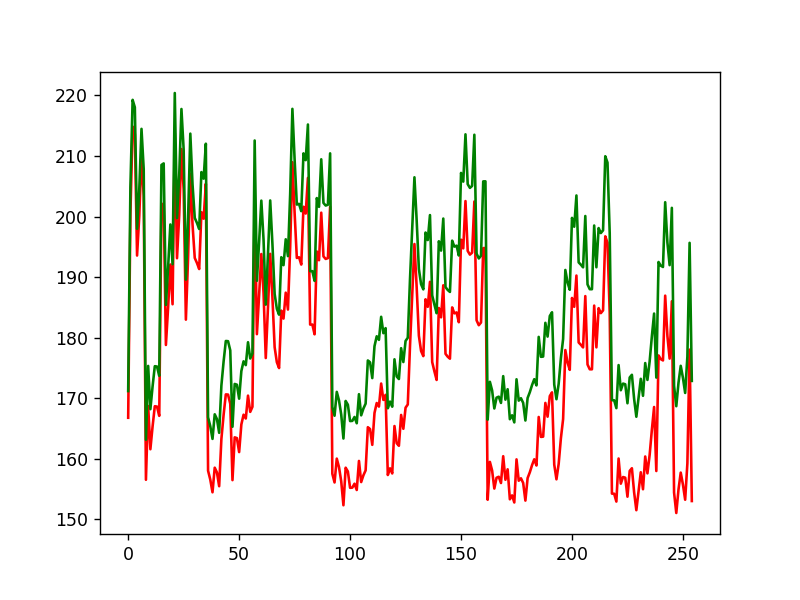

In [52]:
fig,ax = plt.subplots()
ax.plot(results_df.aic,'r')
ax.plot(results_df.bic,'g')

### Crossvalidation (5-fold)